# **Inspiration**
In an aging society, medicare has becoming inceasingly vital. Unfortunately, with modern US Healthcare programs’ complexity and sophistication, fraud losses in healthcare cost US taxpayers a staggering amount, to quote from the Justice Department,

> "Health care fraud costs the United States tens of billions of dollars each year. Some estimates put the figure close to \$100 billion a year.  It is a rising threat, with national health care expenditures estimated to exceed \$3 trillion in 2014." 
[- U.S. Department of Justice](http://www.justice.gov/criminal-fraud/health-care-fraud-unit)

# **Goals**
Using High Performance Computer Cluster (HPCC), we aim to tackle this data using a big data-driven approach, particularly we hope to:
1. Detect patterns of fraud medicare providers.
2. Build classification models to detect these providers.

Solutions to all problems start with gathering data and seeing the big picture through big data analytics lens, here we employed a combination of data from the [CMS Medicare 2014 Part D data](https://cloud.google.com/bigquery/public-data/medicare) from Google BigQuery (21 million observations), [Medicare Exclusion list ](https://oig.hhs.gov/exclusions/exclusions_list.asp#instruct) from the Office of Inspector General, and a [geographical dataset](https://simplemaps.com/data/us-cities).

# **Results & Discussions**
All graphical results and discussions were generated suing Plotly **and are not kept in the notebook** please refer to https://plot.ly/~tpjoe33/12/catching-medicare-fraud-providers-from-sale-anomalies/ to see the dashboard of these results as well as the analyses.


# Table of contents
1. [Medicare Data Exploration](#medExp)
    1. [Top 10 Drugs in Medicare](#medTop)
    2. [Who Use Medicare?](#medUse)
    3. [Medicare Drug Price Disparity across States](#medMap)
2. [Exploring Excluded Providers](#excProvider)
    1. [Top 10 Drugs Sold by Excluded Providers](#excDrug)
    2. [Drug Selling Statistics of Excluded Providers](#excBehavior)
    3. [Specialty of Exlcuded Providers](#excSpecialty)
    4. [Statistical Analysis of Fraud Providers](#excStats)
3. [Classification Models](#classModel)
    1. [Classification of Drug Providers](#classPro)
        1. [Principal Components Analysis](#classPCA)
        2. [Training without Resampling](#classNoUpDown)
        3. [Training after Upsampling](#classUpDown)
    2. [Classification Models Comparison](#compModel)
    3. [Model Optimization](#optModel)
        1. [Grid Search CV](#optGrid)
        2. [OptimizingPCA Components](#optPCA)

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import glob, os    
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
import addfips
from scipy.stats import f_oneway, spearmanr
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='tpjoe33', api_key='rc1Ncjms567YGfGS9VlU')

states = ['AK', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', \
          'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', \
          'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', \
          'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', \
          'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI',' WY']

In [2]:
# importing data
part_d_exp_df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('Data/cms_medicare_test/', \
                                                              "part_d_prescriber_2014*.csv"))))
exclusion_df = pd.read_csv('Data/Exclusion_list.csv', low_memory=False)

part_d_exp_df = part_d_exp_df[['npi', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'description_flag',\
                        'drug_name', 'generic_name', 'bene_count', 'total_claim_count','total_day_supply', \
                        'total_drug_cost', 'bene_count_ge65', 'total_claim_count_ge65', 'total_day_supply_ge65',\
                        'total_drug_cost_ge65']]

# assigning exclusion (False = 0, True = 1)
exclusion_npi = exclusion_df['NPI'][exclusion_df['NPI'] != 0].values.tolist()
part_d_exp_df['is_excluded'] = 0
num_excluded = len(part_d_exp_df.loc[part_d_exp_df['npi'].isin(exclusion_npi)])
part_d_exp_df.loc[part_d_exp_df['npi'].isin(exclusion_npi), 'is_excluded'] = 1

# separating dataset for training models and for data exploration
part_d_df = part_d_exp_df[['npi', 'nppes_provider_city', 'nppes_provider_state', 'specialty_description', \
                      'drug_name', 'total_claim_count', 'total_day_supply', 'total_drug_cost', 'is_excluded']]
part_d_exp_df = part_d_exp_df[part_d_df['nppes_provider_state'].isin(states)]

print("The data has a size of {}".format(part_d_df.shape))

/mnt/home/phongpre/anaconda3-singularity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



The data has a size of (24121659, 9)


# Medicare Data Exploration <a name="medExp"></a>

In [3]:
# Comparing statistics to show that just 1/10th of the data is sufficient

# importing data
part_d_exp_df_small = pd.concat(map(pd.read_csv, glob.glob(os.path.join('Data/cms_medicare_test/', \
                                                              "part_d_prescriber_2014000000000000.csv"))))

part_d_exp_df_small = part_d_exp_df_small[['npi', 'nppes_provider_city','nppes_provider_state', 'specialty_description', \
                        'description_flag',\
                        'drug_name', 'generic_name', 'bene_count', 'total_claim_count','total_day_supply', \
                        'total_drug_cost', 'bene_count_ge65', 'total_claim_count_ge65', 'total_day_supply_ge65',\
                        'total_drug_cost_ge65']]

# assigning exclusion (False = 0, True = 1)
part_d_exp_df_small['is_excluded'] = 0
num_excluded = len(part_d_exp_df_small.loc[part_d_exp_df_small['npi'].isin(exclusion_npi)])
part_d_exp_df_small.loc[part_d_exp_df_small['npi'].isin(exclusion_npi), 'is_excluded'] = 1

# separating dataset for training models and for data exploration
part_d_df = part_d_exp_df_small[['npi', 'nppes_provider_city', 'nppes_provider_state', 'specialty_description', \
                      'drug_name', 'total_claim_count', 'total_day_supply', 'total_drug_cost', 'is_excluded']]
part_d_exp_df_small = part_d_exp_df_small[part_d_exp_df_small['nppes_provider_state'].isin(states)]

print("The data has a size of {}".format(part_d_exp_df_small.shape))

/mnt/home/phongpre/anaconda3-singularity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



The data has a size of (2370690, 16)


In [4]:
# Some basic statistics
part_d_exp_df.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
0,1780617977,LAKELAND,FL,Internal Medicine,S,CLOPIDOGREL,CLOPIDOGREL BISULFATE,18.0,131,3424,1675.80,18.0,131.0,3424.0,1675.80,0
1,1386698769,MADISON,WI,Internal Medicine,S,LOVASTATIN,LOVASTATIN,54.0,204,15935,3503.89,NaN,191.0,15571.0,3383.69,0
2,1639266943,PARAMUS,NJ,Psychiatry,S,DIVALPROEX SODIUM ER,DIVALPROEX SODIUM,72.0,625,19241,83359.87,15.0,127.0,3838.0,12314.47,0
3,1265530091,VINELAND,NJ,Neurology,S,PRIMIDONE,PRIMIDONE,20.0,107,4300,3274.06,NaN,63.0,2730.0,1894.44,0
4,1336300433,HUEYTOWN,AL,Family Practice,S,MONTELUKAST SODIUM,MONTELUKAST SODIUM,28.0,95,4110,3768.61,NaN,63.0,2670.0,2455.28,0


In [5]:
description = part_d_exp_df.drop(['npi'], axis=1).describe()
drug_cost = part_d_exp_df.total_drug_cost.sum()
n_providers = len(part_d_exp_df['npi'].unique())
n_drugs = len(part_d_exp_df['drug_name'].unique())
description

,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
count,8.917242e+06,2.369819e+07,2.369819e+07,2.369819e+07,3.252909e+06,1.376405e+07,1.376405e+07,1.376405e+07,2.369819e+07
mean,2.815924e+01,5.068579e+01,2.032655e+03,3.921015e+03,1.922530e+01,4.723445e+01,1.994020e+03,3.156197e+03,1.492182e-03
std,3.471427e+01,8.534779e+01,3.668137e+03,2.518444e+04,4.549501e+01,8.564511e+01,3.774252e+03,1.704328e+04,3.859994e-02
min,1.100000e+01,1.100000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,1.500000e+01,4.500000e+02,2.726400e+02,0.000000e+00,1.300000e+01,3.900000e+02,2.110900e+02,0.000000e+00
50%,1.900000e+01,2.400000e+01,9.000000e+02,7.289100e+02,1.300000e+01,2.100000e+01,8.400000e+02,6.336500e+02,0.000000e+00
75%,3.200000e+01,5.000000e+01,1.980000e+03,2.529830e+03,2.300000e+01,4.600000e+01,1.890000e+03,2.257440e+03,0.000000e+00
max,2.784600e+04,2.791000e+04,4.870920e+05,1.299307e+07,2.634400e+04,2.640300e+04,4.616540e+05,6.352059e+06,1.000000e+00


In [6]:
description_small = part_d_exp_df_small.drop(['npi'], axis=1).describe()
drug_cost_small = part_d_exp_df_small.total_drug_cost.sum()
n_providers_small = len(part_d_exp_df_small['npi'].unique())
n_drugs_small = len(part_d_exp_df_small['drug_name'].unique())
description_small

,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
count,891887.000000,2.370690e+06,2.370690e+06,2.370690e+06,325790.000000,1.376967e+06,1.376967e+06,1.376967e+06,2.370690e+06
mean,28.121495,5.061300e+01,2.029100e+03,3.896101e+03,19.180982,4.719371e+01,1.991088e+03,3.153375e+03,1.507578e-03
std,31.892433,8.486771e+01,3.654336e+03,2.636795e+04,39.753690,8.481081e+01,3.754481e+03,1.771318e+04,3.879827e-02
min,11.000000,1.100000e+01,8.000000e+00,1.000000e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,14.000000,1.500000e+01,4.500000e+02,2.729500e+02,0.000000,1.300000e+01,3.900000e+02,2.113200e+02,0.000000e+00
50%,19.000000,2.400000e+01,9.000000e+02,7.290700e+02,13.000000,2.100000e+01,8.400000e+02,6.344500e+02,0.000000e+00
75%,32.000000,5.000000e+01,1.980000e+03,2.531090e+03,23.000000,4.600000e+01,1.890000e+03,2.256080e+03,0.000000e+00
max,12576.000000,1.261500e+04,1.973270e+05,9.534891e+06,11044.000000,1.107600e+04,1.823230e+05,6.352059e+06,1.000000e+00


In [7]:
# Summary
print('In full dataset, there are {} observations in the dataset. These account to a total of ${:.0f} \
of drug sold from {} unique providers with {} unique drugs.'.format(len(part_d_exp_df), drug_cost, n_providers,
                                                                           n_drugs))
print('In 1/10th dataset, there are {} observations in the dataset. These account to a total of ${:.0f} \
of drug sold from {} unique providers with {} unique drugs.'.format(len(part_d_exp_df_small), drug_cost_small, 
                                                                           n_providers_small, n_drugs_small))

In full dataset, there are 23698188 observations in the dataset. These account to a total of $92920947288 of drug sold from 824785 unique providers with 2695 unique drugs.
In 1/10th dataset, there are 2370690 observations in the dataset. These account to a total of $9236446768 of drug sold from 479217 unique providers with 2190 unique drugs.


In [8]:
# Since the smaller sample (1/10) has the same statistics of interest with the population we use it for the rest of the 
#analysis
part_d_exp_df = part_d_exp_df_small

In [9]:
tqdm.pandas()
county_ref = pd.read_csv('Data/uscitiesv1.4.csv')
county_ref['city'] = county_ref['city'].apply(str.upper)
def get_fip(city, state):
    #if all(x in county_ref[['city', 'state']].values for x in [city, state]):
    try:
        county = county_ref[(county_ref['city'] == city.upper()) &\
                            (county_ref['state_id'] == state.upper())]['county_fips'].values[0]
    except IndexError:
        county = None
    return county

In [10]:
# Dataprocessing

# generating drug cost and count per beneficiary
part_d_exp_df['cost_per_bene'] = part_d_exp_df['total_drug_cost']/part_d_exp_df['bene_count']
part_d_df_city_mean = part_d_exp_df.groupby(['nppes_provider_state', 'nppes_provider_city']).mean()
part_d_df_city_mean = part_d_df_city_mean.reset_index()
part_d_df_city_mean['fip'] = part_d_df_city_mean.apply(lambda x: get_fip(x['nppes_provider_city'], \
                                                                         x['nppes_provider_state']), axis=1)

part_d_df_state_sum = part_d_exp_df.groupby(['nppes_provider_state']).sum()
part_d_df_state_sum = part_d_df_state_sum.reset_index()

In [11]:
part_d_exp_df.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,cost_per_bene
0,1205995735,GRAND RAPIDS,MI,Psychiatry,S,RISPERIDONE,RISPERIDONE,34.0,448,12858,5699.76,NaN,47.0,1328.0,514.74,0,167.640000
1,1073887618,NEW KENSINGTON,PA,Nurse Practitioner,S,METOPROLOL TARTRATE,METOPROLOL TARTRATE,16.0,73,3307,501.37,NaN,62.0,2797.0,443.34,0,31.335625
2,1114960846,CHESTER,VA,Internal Medicine,S,GABAPENTIN,GABAPENTIN,30.0,166,5794,3628.69,NaN,139.0,4804.0,2963.24,0,120.956333
3,1801991666,GREAT NECK,NY,Internal Medicine,S,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE,15.0,87,2610,646.41,15.0,87.0,2610.0,646.41,0,43.094000
4,1811907694,MARSHFIELD,WI,Internal Medicine,S,LEVOTHYROXINE SODIUM,LEVOTHYROXINE SODIUM,27.0,124,8261,2708.21,NaN,94.0,7248.0,2270.92,0,100.304074


## Top selling drugs <a name="medTopDrug"></a>

In [12]:
# Finding top selling drugs
top_drug_price = part_d_exp_df.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_count = part_d_exp_df.groupby('drug_name').count().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_price.head(10)

,npi,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,cost_per_bene
drug_name,,,,,,,,,,,
SOVALDI,334919957399,1744.0,8947,249392,2.532243e+08,373.0,2285.0,63224.0,6.431152e+07,0,6.164863e+06
NEXIUM,20578028524294,96729.0,692355,28155650,2.408225e+08,18694.0,361872.0,14706560.0,1.240598e+08,22,7.415842e+06
CRESTOR,22117503819936,142493.0,859939,40713416,2.405247e+08,33921.0,496053.0,23392926.0,1.378722e+08,13,7.805963e+06
ABILIFY,7661119508988,27551.0,256137,7293705,2.136049e+08,1748.0,65995.0,1652197.0,4.553688e+07,17,5.776493e+06
ADVAIR DISKUS,19315096251503,92472.0,548362,20763376,2.047796e+08,19869.0,277076.0,10617701.0,1.038534e+08,22,6.195569e+06
SPIRIVA,17582920119114,78336.0,528665,20295794,1.939975e+08,18825.0,290282.0,11250585.0,1.073756e+08,20,5.204506e+06
LANTUS SOLOSTAR,14702887588234,58788.0,390512,16936843,1.768381e+08,11568.0,187130.0,8350922.0,8.261926e+07,17,5.044376e+06
JANUVIA,14287035026624,42439.0,406914,16278137,1.580359e+08,8702.0,239398.0,9493881.0,9.208358e+07,22,4.436018e+06
REVLIMID,728285969853,846.0,15988,420658,1.499158e+08,361.0,10735.0,283501.0,1.002989e+08,0,1.826141e+06


In [13]:
# plotting use top ten drugs by price and amount
trace_price = go.Bar(x=top_drug_price.index, y=top_drug_price['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(000,000,102)', width=1.5)),
                     opacity = 0.8)
                     
trace_count = go.Bar(x=top_drug_count.index, y=top_drug_count['total_drug_cost'], name='by amount', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(13,129,106)', width=1.5)),
                     opacity = 0.8)
data = [trace_price, trace_count]

updatemenus = list([
    dict(
        buttons=list([
            dict(label = 'by price',
                method = 'update',
                args = [{'visible': [True, False]},
                         {'title': 'Top 10 Drugs in Medicare (By Price)'}]),
            dict(label = 'by amount',
                method = 'update',
                args = [{'visible': [False, True]},
                        {'title': 'Top 10 Drugs in Medicare (By Amount)'}])
        ]),
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = .8,
        xanchor = 'left',
        y = 1.1,
        yanchor = 'top' )
    
])
layout = dict(title='Top 10 Drugs in Medicare (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=10, pad=4),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='drug_dropdown')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tpjoe33/0 or inside your plot.ly account where it is named 'drug_dropdown'


## Medicare Use <a name="medUse"></a>

In [14]:
# plotting use of medicare by people of age 65+

trace1 = go.Box(
    y=part_d_df_state_sum.bene_count_ge65/part_d_df_state_sum.bene_count*100,
    name = 'By No. of Beneficiaries',
    boxpoints='all',
    jitter=0.3,
    marker = dict(
        color = 'rgb(102,204,255)'
    ),
    boxmean=True
)

trace2 = go.Box(
    y=part_d_df_state_sum.total_claim_count_ge65/part_d_df_state_sum.total_claim_count*100,
    name = 'By No. of Claims',
    boxpoints='all',
    jitter=0.3,
    boxmean=True,
    marker = dict(
        color = 'rgb(051,153,255)'
    )
)

trace3 = go.Box(
    y=part_d_df_state_sum.total_drug_cost_ge65/part_d_df_state_sum.total_drug_cost*100,
    name = 'By Cost of Claims',
    boxpoints='all',
    jitter=0.3,
    boxmean=True,
    marker = dict(
        color='rgb(000,051,153)'
    )
)


layout = go.Layout(
    title='Medicare Precsription Used by Beneficiaries of 65+ Age',
    width=500,
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        autotick=True,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        title='Percentages (%)',
        zeroline=False
    ),
    legend=dict(
        orientation='h'
    ),
)

data = [trace1, trace2, trace3]
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='alcohol-box-plot')

## Drug Price Disparity across the States <a name="medMap"></a>

In [15]:
# plotting choropleth for drug price disparity

part_d_df_city_mean_plt = part_d_df_city_mean[['fip', 'cost_per_bene']].dropna().groupby('fip').mean()

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(1, part_d_df_city_mean_plt.describe(percentiles=[.90]).values[5], len(colorscale) - 1))

fips = part_d_df_city_mean_plt.index.tolist()
values = part_d_df_city_mean_plt['cost_per_bene'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=3.2, title='Average Medicare Prescription Cost in the USA',
    legend_title='Average Cost per Beneficiary'
)
#py.iplot(fig, filename='choropleth_medicare_cost')

# Exploring Excluded Providers <a name="excProvider"></a>

## Top ten drugs sold by excluded proviers <a name="excDrug"></a>

In [16]:
# Top 10 drugs sold by excluded providers
excluded_providers = part_d_exp_df.loc[part_d_exp_df['is_excluded'] == 1]
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]

# Plotting
trace_ex_price = go.Bar(x=excluded_drug_rank.index, y=excluded_drug_rank['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(255,204,204)', line=dict(color='rgb(204,000,000)', width=1.5)),
                     opacity = 0.8)  
data = [trace_ex_price]
layout = dict(title='Top 10 Drugs in Medicare Sold by Excluded Providers (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=50, pad=4))

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='drug_excluded')

## Exploring drug selling statistics of excluded providers <a name="excBehavior"></a>

In [17]:
# Assigning narcotics/opioid (False = 0, True = 1)
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False)
common_narcotics = ['OXYCONTIN', 'OXYMORPHONE HCL ER', 'MORPHINE SULFATE ER', 'OXYCODONE HCL', 'OXYCODONE-ACETAMINOPHEN', \
                    'FENTORA', 'SUBSYS', 'HYDROCODONE-ACETAMINOPHEN', 'SUBOXONE', 'OPANA ER', 'HYDROCODONE-ACETAMINOPHEN']
part_d_exp_df['is_narcotics'] = 0
part_d_exp_df.loc[part_d_df['drug_name'].isin(common_narcotics), 'is_narcotics'] = 1

In [18]:
behavior = part_d_exp_df[['total_claim_count', 'total_drug_cost', 'total_day_supply', \
               'is_excluded', 'is_narcotics']].groupby(['is_excluded', 'is_narcotics']).mean()
behavior

total_claim_count  total_drug_cost  total_day_supply
is_excluded is_narcotics                                                      
0           0                     49.935872      3890.956328       2043.946186
            1                     72.295154      4016.943804       1543.526095
1           0                     54.859461      3531.811927       1902.011881
            1                    200.796748     41208.777398       5495.056911

In [19]:
#  plotting
data = [{'x': ['Non-excluded Providers', 'Non-excluded Providers ', \
            'Excluded Providers', 'Excluded Providers '],
        'y': behavior['total_drug_cost'].values.tolist(),
        'text': ['Average total amount per beneficiary: {0:.0f}'.format(i) 
                 for i in behavior['total_claim_count'].values.tolist()],
        'mode': 'markers',
        'marker': {
            'color': ['rgb(051,153,255)', 'rgb(255,102,102)', 'rgb(000,051,153)', 'rgb(204,000,000)'],
            'size': behavior['total_claim_count'].values.tolist(),
            'showscale': False
        }
    }
]

annotations=[dict(x='Non-excluded Providers', y=10000, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Non-excluded Providers ', y=12500, xref='x', yref='y', text='Narcotics', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers', y=10500, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers ', y=68000, xref='x', yref='y', text='Narcotics',\
                  showarrow=True, arrowhead=7, ax=0, ay=-40)]

layout = dict(title='Medicare Prescription Cost and Amount by Excluded and Non-excluded Providers', showlegend=False, 
              annotations=annotations, margin=go.Margin(l=50, r=100, b=120, t=50, pad=4), 
              yaxis=dict(title='Average Cost Per Beneficiary ($)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='provider-behavior')

## Exploring Specialties of Excluded Drug Providers <a name="excSpecialty"></a>

In [20]:
# Creating fraction of top 5 specialties from non-excluded and excluded providers
nonexcluded_providers = part_d_exp_df[part_d_exp_df['is_excluded'] == 0]
nonexcluded_providers_specialty = nonexcluded_providers.groupby\
('specialty_description').count().sort_values('npi', ascending=False).head()/len(nonexcluded_providers)*100
nonexcluded_providers_specialty = nonexcluded_providers_specialty['npi'].to_dict()

excluded_providers_specialty = excluded_providers.groupby \
('specialty_description').count().sort_values('npi', ascending=False).head()/len(excluded_providers)*100
excluded_providers_specialty = excluded_providers_specialty['npi'].to_dict()

for i, j in zip(list(nonexcluded_providers_specialty.keys()), list(excluded_providers_specialty.keys())):
    if i not in excluded_providers_specialty.keys():
        excluded_providers_specialty.update({i: 0})
    if j not in nonexcluded_providers_specialty.keys():
        nonexcluded_providers_specialty.update({j: 0})

nonex_ex_specialty = pd.DataFrame(0, index=excluded_providers_specialty.keys(), columns=['nonexcluded', 'excluded'])
nonex_ex_specialty.loc[:, 'nonexcluded'] = pd.Series(nonexcluded_providers_specialty)
nonex_ex_specialty.loc[:, 'excluded'] = pd.Series(excluded_providers_specialty)
nonex_ex_specialty.loc['Others'] = list(100 - nonex_ex_specialty.sum().values)
nonex_ex_specialty

,nonexcluded,excluded
Internal Medicine,28.507052,36.038053
Family Practice,29.893592,27.252378
General Practice,0.000000,6.855064
Psychiatry,0.000000,5.456072
Nurse Practitioner,8.728470,4.392837
Physician Assistant,4.719583,0.000000
Cardiology,4.090590,0.000000
Others,24.060714,20.005596


In [21]:
trace_dict = {}
color = ["#08306b", "#08519c", "#1361a9", "#2171b5", "#4292c6", "#6baed6", "#9ecae1", "#c6dbef"]
for i, specialty in enumerate(nonex_ex_specialty.index):
    trace_dict.update({'trace' + specialty: go.Bar(x=['Non-excluded Providers', 'Excluded Providers'], 
                                     y=nonex_ex_specialty.loc[specialty].values.tolist(),
                                     name=specialty, marker=dict(color=color[i]))})

data = [trace_dict[trace] for trace in trace_dict]

layout = go.Layout(barmode='stack', yaxis=dict(title='Percentages of Provider Specialty (%)'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

## Statistical Analysis of Fraud Providers <a name="excStats"></a>

### Fraud and Typical Providers' Specialty

In [22]:
le = LabelEncoder()
specialty = le.fit_transform(part_d_exp_df['specialty_description'])
labels = part_d_exp_df['is_excluded'].values.tolist()

corr, p = spearmanr(specialty, labels)

print('The Spearman\' correlation between providers\' specialty and whether the provider is fraud is {:.4f} \
with a p-value of {:.4f}.'.format(corr, p))

The Spearman' correlation between providers' specialty and whether the provider is fraud is 0.0023 with a p-value of 0.0003.


### Sale Behaviors Difference Between Fraud and Typical Providers

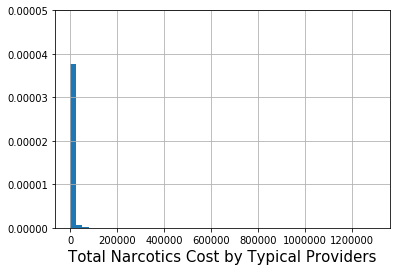

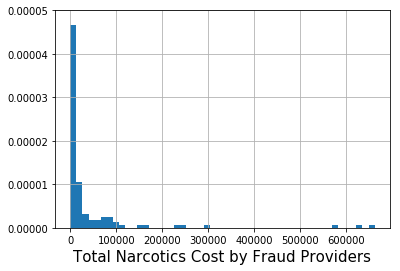

In [23]:
narcotics_by_fraud = part_d_exp_df[(part_d_exp_df['is_excluded'] == 1) & (part_d_exp_df['is_narcotics'] == 1)]
narcotics_by_typical = part_d_exp_df[(part_d_exp_df['is_excluded'] == 0) & (part_d_exp_df['is_narcotics'] == 1)]
all_by_fraud = part_d_exp_df[(part_d_exp_df['is_excluded'] == 1)]
all_by_typical = part_d_exp_df[(part_d_exp_df['is_excluded'] == 0)]

narcotics_by_typical.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Narcotics Cost by Typical Providers', fontsize=15)
plt.savefig('narcotics_by_typical.jpeg', dpi=1000)
plt.ylim([0, 0.00005])
plt.show()
narcotics_by_fraud.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Narcotics Cost by Fraud Providers', fontsize=15)
plt.savefig('narcotics_by_fraud.jpeg', dpi=1000)
plt.ylim([0, 0.00005])
plt.show()

The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value of 0.6987, therefore, we do NOT reject the hypothesis.
The null hypothesis that fraud providers sell narcotics with the same total cost as typical provider has a p-value of 0.0000, therefore, we REJECT the hypothesis.


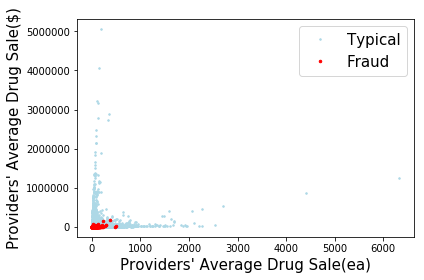

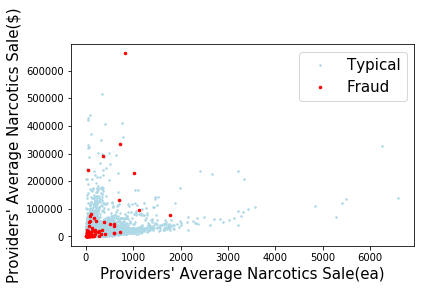

In [24]:
# Narcotic selling statistics of fraud and typical providers
fraud_providers_n = part_d_exp_df[(part_d_exp_df['is_excluded'] == 1) & (part_d_exp_df['is_narcotics'] ==1)].groupby(['npi']).mean()
typical_providers_n = part_d_exp_df[(part_d_exp_df['is_excluded'] == 0) & (part_d_exp_df['is_narcotics'] ==1)].groupby(['npi']).mean()

cost_typical_n = typical_providers_n['total_drug_cost']
cost_fraud_n = fraud_providers_n['total_drug_cost']
amount_typical_n = typical_providers_n['total_claim_count']
amount_fraud_n = fraud_providers_n['total_claim_count']

# All drugs selling statistics of fraud and typical providers
fraud_providers_d = part_d_exp_df[(part_d_exp_df['is_excluded'] == 1)].groupby(['npi']).mean()
typical_providers_d = part_d_exp_df[(part_d_exp_df['is_excluded'] == 0)].groupby(['npi']).mean()

cost_typical_d = typical_providers_d['total_drug_cost']
cost_fraud_d = fraud_providers_d['total_drug_cost']
amount_typical_d = typical_providers_d['total_claim_count']
amount_fraud_d = fraud_providers_d['total_claim_count']

print('The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we do NOT reject the hypothesis.'.format(f_oneway(cost_typical_d, cost_fraud_d)[1]))

print('The null hypothesis that fraud providers sell narcotics with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we REJECT the hypothesis.'.format(f_oneway(cost_typical_n, cost_fraud_n)[1]))


plt.plot(amount_typical_d, cost_typical_d, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_d, cost_fraud_d, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Drug Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Drug Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_d.jpeg', dpi=1000)
plt.show()

plt.plot(amount_typical_n, cost_typical_n, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_n, cost_fraud_n, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Narcotics Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Narcotics Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_n.jpeg', dpi=1000)
plt.show()

# Classification Models <a name="classModel"></a>

In [25]:
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from scipy.stats import pointbiserialr

## Classification of Drug Providers <a name="classPro"></a>

In [26]:
# Creating grouped drug data frame and grouped provider datafrmae
drug_list = sorted(part_d_df['drug_name'][part_d_df['is_excluded']==1].unique())
npi_group = part_d_df.groupby('npi').sum()
npi_drug_group_df = part_d_df.groupby(['drug_name', 'npi']).sum()

In [27]:
print("There are {} unique providers".format(len(npi_group)))
print("There are {} unique drugs, of which {} are sold by excluded provider for at least once." \
      .format(len(npi_drug_group_df), len(drug_list)))

There are 487241 unique providers
There are 2412087 unique drugs, of which 553 are sold by excluded provider for at least once.


In [28]:
# Creating feature tables for input (row=providers, columns=cost fraction of drugs each provider sold)
npi_drug_df = pd.DataFrame(0, index=npi_group.index, columns=drug_list)
for drug in tqdm(drug_list):
    npi_drug_df.loc[npi_drug_group_df.loc[drug][['total_drug_cost']].index, [drug]] = \
    npi_drug_group_df.loc[drug][['total_drug_cost']].values/ \
    npi_group.loc[npi_drug_group_df.loc[drug][['total_drug_cost']].index, ['total_drug_cost']].values
npi_drug_df.head()

100%|██████████| 553/553 [11:30<00:00,  1.25s/it]


,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACTONEL,ACYCLOVIR,ADEFOVIR DIPIVOXIL,ADVAIR DISKUS,ADVAIR HFA,AFEDITAB CR,...,ZETIA,ZIPRASIDONE HCL,ZOHYDRO ER,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONALON,ZONISAMIDE,ZOVIA 1-50E,ZOVIRAX,ZYPREXA RELPREVV
npi,,,,,,,,,,,,,,,,,,,,,
1003000126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Check nulls
print(npi_drug_df.isnull().sum().sum())
npi_drug_df = npi_drug_df.dropna(axis = 0)
print(npi_drug_df.isnull().sum().sum())
print(npi_drug_df.shape)

# Saving
npi_drug_df.to_pickle('npi_drug_df.pickle')
npi_group.to_pickle('npi_group.pickle')

0
0
(487241, 553)


In [30]:
# Loading
npi_drug_df = pd.read_pickle('npi_drug_df.pickle')
npi_group = pd.read_pickle('npi_group.pickle')

In [31]:
npi_drug_df.head()

,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACTONEL,ACYCLOVIR,ADEFOVIR DIPIVOXIL,ADVAIR DISKUS,ADVAIR HFA,AFEDITAB CR,...,ZETIA,ZIPRASIDONE HCL,ZOHYDRO ER,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONALON,ZONISAMIDE,ZOVIA 1-50E,ZOVIRAX,ZYPREXA RELPREVV
npi,,,,,,,,,,,,,,,,,,,,,
1003000126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003000423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Applying PCA <a name="classPCA"></a>

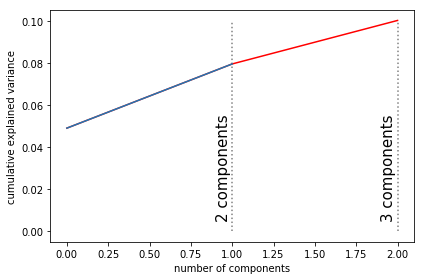

In [32]:
# Applying PCA (2 components), but we will plot both 3 and 2 components for visualization of vairance explained

pca = decomposition.PCA(n_components=3)
pca.fit(npi_drug_df)
npi_drug_df_transformed = pca.transform(npi_drug_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='r')

pca = decomposition.PCA(n_components=2)
pca.fit(npi_drug_df)
npi_drug_df_transformed = pca.transform(npi_drug_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.vlines(1, color='grey', ymax=0.1, ymin=0, linestyle=':')
plt.vlines(2, color='grey', ymax=0.1, ymin=0, linestyle=':')

plt.annotate('2 components', xy=(0.6, 0.05), xytext=(0.9, 0.05), fontsize=15, rotation=90)
plt.annotate('3 components', xy=(1.6, 0.05), xytext=(1.9, 0.05), fontsize=15, rotation=90)

plt.savefig('VarExp.jpeg', dpi=1000)
plt.tight_layout()
plt.show()

In [33]:
npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
df = pd.concat([pd.DataFrame(npi_drug_df_transformed, index=npi_label.index), npi_label], axis=1)

In [34]:
npi_label['is_excluded'].value_counts()

0    486675
1       566
Name: is_excluded, dtype: int64

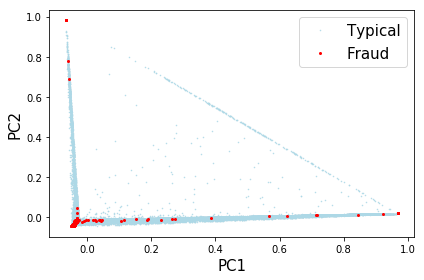

In [35]:
df_fraud = df[df['is_excluded'] == 1]
df_typical = df[df['is_excluded'] == 0]

#fig = plt.figure()
#ax = fig.add_subplot()

plt.plot(df_typical[0].values.tolist(), df_typical[1].values.tolist(), \
        markersize=1, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(df_fraud[0].values.tolist(), df_fraud[1].values.tolist(), \
        markersize=4, linestyle='none', marker='.', color='r', label='Fraud')

plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('PC2.jpeg', dpi=1000)
plt.show()

/mnt/home/phongpre/anaconda3-singularity/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



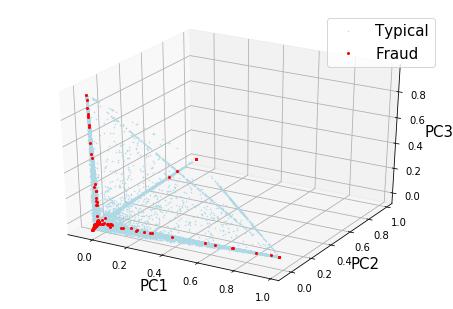

In [36]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)


pca = decomposition.PCA(n_components=3)
pca.fit(npi_drug_df)
npi_drug_df_transformed = pca.transform(npi_drug_df)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
#plt.show()

npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
df3 = pd.concat([pd.DataFrame(npi_drug_df_transformed, index=npi_label.index), npi_label], axis=1)

df_fraud = df3[df3['is_excluded'] == 1]
df_typical = df3[df3['is_excluded'] == 0]

ax.plot(df_typical[0].values.tolist(), df_typical[1].values.tolist(), df_typical[2].values.tolist(), \
        markersize=1, linestyle='none', marker='.', color='lightblue', label='Typical')
ax.plot(df_fraud[0].values.tolist(), df_fraud[1].values.tolist(), df_fraud[2].values.tolist(), \
        markersize=4, linestyle='none', marker='.', color='r', label='Fraud')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig('PC3.jpeg', dpi=1000)
plt.show()

### Training without down/upsampling <a name="classNoUpDown"></a>

In [37]:
X = df.drop(['is_excluded'], axis=1)
y = df['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.99083152887


array([[326078,      0],
       [   108,    265]])

In [39]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.459466235133


array([[160596,      1],
       [   193,      0]])

From the confusion matrix, we can see that the model was unable to capture the minor class.

### With upsampling/downsampling <a name="classUpDown"></a>

### Results from upsampling only

In [40]:
# Upsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    486675
1      5480
Name: is_excluded, dtype: int64

In [41]:
X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.989403719429


array([[326045,     12],
       [   748,   2938]])

In [43]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.985691803869


array([[160577,     41],
       [   413,   1381]])

### Results from downsampling only

In [44]:
# Downsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=48670, random_state=42) # Reduce by 10 times
df_downsampled = pd.concat([df_majority_downsampled, df_minority]) 
df_downsampled['is_excluded'].value_counts()

0    48670
1      566
Name: is_excluded, dtype: int64

In [45]:
X = df_downsampled.drop(['is_excluded'], axis=1)
y = df_downsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [46]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.985232434081


array([[32608,     0],
       [   94,   286]])

In [47]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.464190676451


array([[16057,     5],
       [  185,     1]])

### Results from combining up and down sampling

In [48]:
# Downsampling+Upsampling
df_updownsampled = pd.concat([df_majority_downsampled, df_minority_upsampled]) 
df_updownsampled['is_excluded'].value_counts()

0    48670
1     5480
Name: is_excluded, dtype: int64

In [49]:
X = df_updownsampled.drop(['is_excluded'], axis=1)
y = df_updownsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.987987679252


array([[32553,    76],
       [  635,  3016]])

In [51]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.982311864938


array([[15926,   115],
       [  314,  1515]])

In conclusion, results from just upsampling only is the best.

## Classification Models Comparison <a name="compModel"></a>

In [52]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

seed = 42

In [53]:
# Upsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    486675
1      5480
Name: is_excluded, dtype: int64

In [54]:
df_upsampled.head()

,0,1,is_excluded
npi,,,
1003000126,-0.032404,-0.017284,0
1003000142,0.771740,0.012141,0
1003000167,-0.040800,0.308674,0
1003000407,-0.037871,-0.025819,0
1003000423,-0.028024,-0.012454,0


In [55]:
# Identifying the best model algorithm
colors = ["#08306b", "#08519c", "#1361a9", "#4292c6", "#6baed6", 'rgb(76,000,153)', 'rgb(153,000,153)']

X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'}

names = ["Naive Bayes", "Nearest Neighbors", "RBF SVM", 
         "AdaBoost", "GradientBoost", "ExtraTrees", "Random Forest"]
        
classifiers = [
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", C=1, probability=True),
    AdaBoostClassifier(n_estimators=50, random_state=seed),
    GradientBoostingClassifier(n_estimators=1000, random_state=seed),
    ExtraTreesClassifier(n_estimators=50, random_state=seed),
    RandomForestClassifier(n_estimators=50, random_state=seed),]

trace_dict = {}
# iterate over classifiers
for color, name, clf in tqdm_notebook(zip(colors, names, classifiers), total=len(names)):
    cv_results = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
    print('########################### \nFor {}'.format(name))
    for score in scoring:
        print('{0:s}: Mean-{1:.4f}  STD-{2:.4f}'.format(score, cv_results['test_'+score].mean(),\
                                                        cv_results['test_'+score].std()))
    trace_dict.update({'trace' + name: go.Bar(x=name, y=cv_results['test_F1'].mean(), error_y=dict(type='data',
                                              array=np.std(cv_results['test_F1']),visible=True),
                                              name=name, marker=dict(color=color), showlegend=False)})


layout = go.Layout(
    title='Performance of Different Models by F1 Score',
    #width=500,
    xaxis=dict(autorange=True, showgrid=False, zeroline=False, showline=False, autotick=True, ticks='',
               showticklabels=True),
    yaxis=dict(title='F1 Score', zeroline=False),
    margin=go.Margin(l=50, r=65, b=100, t=60, pad=4))

data = [trace_dict[trace] for trace in trace_dict]
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='F1models')

A Jupyter Widget

########################### 
For Naive Bayes
AUC: Mean-0.5243  STD-0.0063
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For Nearest Neighbors
AUC: Mean-0.9068  STD-0.0030
Accuracy: Mean-0.9941  STD-0.0003
F1: Mean-0.7459  STD-0.0107
########################### 
For RBF SVM
AUC: Mean-0.4882  STD-0.0118
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For AdaBoost
AUC: Mean-0.6338  STD-0.0060
Accuracy: Mean-0.9889  STD-0.0000
F1: Mean-0.0000  STD-0.0000
########################### 
For GradientBoost
AUC: Mean-0.9650  STD-0.0041
Accuracy: Mean-0.9937  STD-0.0003
F1: Mean-0.6540  STD-0.0190
########################### 
For ExtraTrees
AUC: Mean-0.9875  STD-0.0015
Accuracy: Mean-0.9975  STD-0.0001
F1: Mean-0.8728  STD-0.0048
########################### 
For Random Forest
AUC: Mean-0.9860  STD-0.0016
Accuracy: Mean-0.9974  STD-0.0001
F1: Mean-0.8707  STD-0.0050



In [56]:
# Plotting ROC curves of the models
colors = ["#08306b", "#08519c", "#1361a9", "#4292c6", "#6baed6", 'rgb(76,000,153)', 'rgb(153,000,153)']
names = ["Naive Bayes", "Nearest Neighbors", "RBF SVM", 
         "AdaBoost", "GradientBoost", "ExtraTrees", "Random Forest"]

X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']


X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)
n_classes = 1

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure()
lw = 2
trace_dict = {}

classifiers = [
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", C=1, probability=True),
    AdaBoostClassifier(n_estimators=50, random_state=seed),
    GradientBoostingClassifier(n_estimators=1000, random_state=seed),
    ExtraTreesClassifier(n_estimators=50, random_state=seed),
    RandomForestClassifier(n_estimators=50, random_state=seed)]

for color, name, clf in tqdm_notebook(zip(colors, names, classifiers), total=len(names)):
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr[name], tpr[name], _ = roc_curve(y_test[:], y_score[:, 1])
    roc_auc[name] = auc(fpr[name], tpr[name])
    trace_dict.update({'trace' + name: go.Scatter(x=fpr[name], y=tpr[name], mode='lines', 
                                       line=dict(color=color, width=lw),
                                       showlegend=True,
                                       name='{0:s} AUC: {1:.2f}'.format(name, roc_auc[name]))})

trace_guess = go.Scatter(x=[0, 1], y=[0, 1], 
                mode='lines', 
                line=dict(color='navy', width=lw, dash='dash'),
                showlegend=False)

data = [trace_dict[trace] for trace in trace_dict] + [trace_guess]

layout = go.Layout(title='Receiver Operating Characteristics',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   margin=go.Margin(l=50, r=50, b=30, t=65, pad=4),
                   legend=dict(x=0.7, y=0.4, font=dict(size=18))
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ROCs')

A Jupyter Widget

## Model Optimization <a name="optModel"></a>

### Grid Search <a name="optGrid"></a>

In [57]:
# Gridsearch of the best algorithm
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer

X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

scoring = {'AUC': 'roc_auc', 'F1': 'f1'}

clf = ExtraTreesClassifier()
params ={'n_estimators': [75, 100, 150, 200, 250, 300], 'max_features':('auto', None), \
         'min_samples_split': [2, 4]}

gs = GridSearchCV(clf, params, scoring=scoring, cv=3, refit='F1', verbose=1)

gs.fit(X, y)
results = gs.cv_results_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 67.6min finished


In [58]:
gs.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Optimizing PCA components <a name="optPCA"></a>

In [59]:
npi_drug_df = pd.read_pickle('npi_drug_df.pickle')
npi_group = pd.read_pickle('npi_group.pickle')

pcas = [1, 2, 3, 5] #20, 50, 100]
F1_avg = []
F1_std = []
prec_avg = []
prec_std = []
recall_avg = []
recall_std = []

scoring = {'prec': 'precision', 'recall': 'recall', 'F1': 'f1'}

clf = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

for pca in tqdm_notebook(pcas):
    pca = decomposition.PCA(n_components=pca)
    pca.fit(npi_drug_df)
    npi_drug_df_transformed = pca.transform(npi_drug_df)
    npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
    df = pd.concat([pd.DataFrame(npi_drug_df_transformed, index=npi_label.index), npi_label], axis=1)

    df_majority = df[df['is_excluded'] == 0]
    df_minority = df[df['is_excluded'] > 0]

    df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
    df_upsampled['is_excluded'].value_counts()
    X = df_upsampled.drop(['is_excluded'], axis=1)
    y = df_upsampled['is_excluded']

    cv_results = cross_validate(clf, X, y, scoring=scoring, cv=3, return_train_score=False)
    F1_avg.append(cv_results['test_F1'].mean())
    F1_std.append(np.std(cv_results['test_F1']))
    prec_avg.append(cv_results['test_prec'].mean())
    prec_std.append(np.std(cv_results['test_prec']))
    recall_avg.append(cv_results['test_recall'].mean())
    recall_std.append(np.std(cv_results['test_recall']))
    
# Plotting
data = [go.Scatter(x=pcas, y=F1_avg, error_y=dict(type='data', array=F1_std, visible=True, color="#6baed6", thickness=1.5),
                  marker=dict(color="#9ecae1",size=8))]

layout = go.Layout(
    title='Performance of Random Forest with Increasing Components',
    #width=500,
    xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=False, autotick=True, ticks='',
               showticklabels=True, title='Number of Components'),
    yaxis=dict(title='F1 Score', zeroline=False))

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='PCAEffects')

A Jupyter Widget

In [60]:
print(prec_avg)
print(prec_std)
print(recall_avg)
print(recall_std)

[0.83406932192084049, 0.98339384662382046, 0.98727058276672464, 0.98569544681954469]
[0.0067902392995953936, 0.0059130734892458535, 0.0075255581821799403, 0.0079151057653170064]
[0.76149570167019265, 0.78430645505842855, 0.78430645505842855, 0.78430645505842855]
[0.0090699373780474598, 0.0078333762893784305, 0.0078333762893784305, 0.0078333762893784305]
